In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import KFold
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
train_data = pd.read_csv('C:/Users/KIIT/Projects/Recipe Recommendation/recipes.csv')
test_data = pd.read_csv('C:/Users/KIIT/Projects/Recipe Recommendation/test_recipes.csv')

In [3]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words if word not in ENGLISH_STOP_WORDS]
        return ' '.join(words)
    return ""

In [4]:
train_data['ingredients_cleaned'] = train_data['ingredients'].apply(preprocess_text)
test_data['ingredients_cleaned'] = test_data['Ingredients'].apply(preprocess_text)

train_data['directions_cleaned'] = train_data['directions'].apply(preprocess_text)
test_data['directions_cleaned'] = test_data['Directions'].apply(preprocess_text)

train_data['combined_features'] = train_data['ingredients_cleaned'] + " " + train_data['directions_cleaned']
test_data['combined_features'] = test_data['ingredients_cleaned'] + " " + test_data['directions_cleaned']

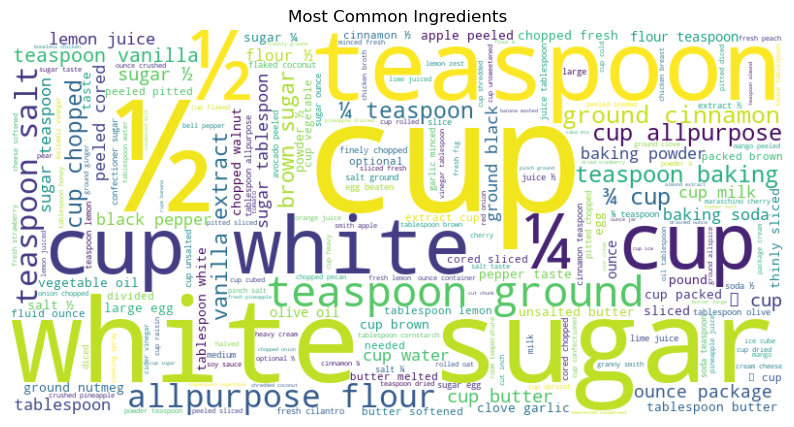

In [5]:
all_ingredients = " ".join(train_data['ingredients_cleaned'])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_ingredients)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Ingredients")
plt.show()

In [6]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train = vectorizer.fit_transform(train_data['combined_features']).toarray()
X_test = vectorizer.transform(test_data['combined_features']).toarray()

In [7]:
y_train = train_data['recipe_name']
y_test = test_data['Name']

In [8]:
svm_model = SVC(kernel='linear', probability=True, random_state=42)
nb_model = MultinomialNB()

In [9]:
kfold = KFold(n_splits=3, shuffle=True, random_state=42)

param_grid = {'C': [0.1, 1, 10]}
grid_search = GridSearchCV(
    svm_model,
    param_grid,
    cv=kfold,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train, y_train)

svm_model = grid_search.best_estimator_

In [10]:
nb_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)

SVC(C=10, kernel='linear', probability=True, random_state=42)

In [11]:
svm_predictions = svm_model.predict(X_test)
nb_predictions = nb_model.predict(X_test)

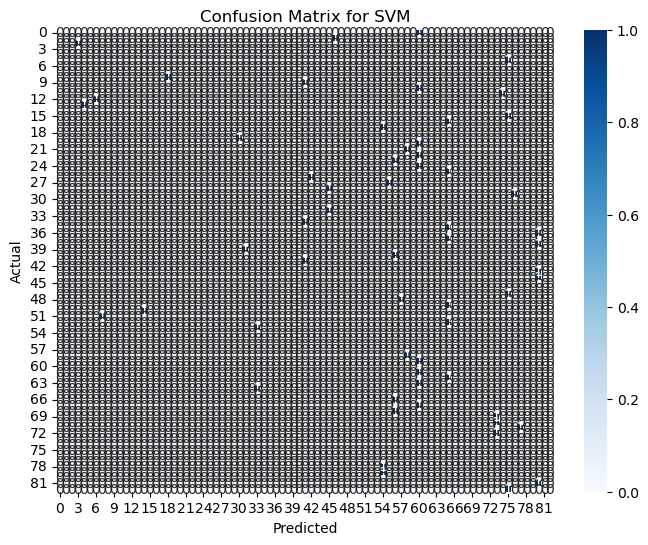

In [12]:
# Visualization: Confusion Matrix for SVM
conf_matrix = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for SVM")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [13]:
# User Interaction
def recommend_recipe(user_ingredients):
    input_text = preprocess_text(" ".join(user_ingredients))
    input_vector = vectorizer.transform([input_text]).toarray()

    # Calculate cosine similarity
    similarities = cosine_similarity(input_vector, X_train)
    top_indices = similarities[0].argsort()[-3:][::-1]

    print("\nTop 3 Recommended Recipes:")
    for i, index in enumerate(top_indices):
        recipe = train_data.iloc[index]
        print(f"\nRecipe {i + 1}: {recipe['recipe_name']}")
        print("Ingredients:", recipe['ingredients'])
        print("Directions:", recipe['directions'])

In [ ]:
user_ingredients = input("Enter the ingredients you have (comma-separated): ").split(",")
recommend_recipe(user_ingredients)